In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# Parámetros físicos
m = 0.38  # masa de cada varilla (kg)
l = 0.31  # longitud de cada varilla (m)
g = 9.77  # aceleración gravitacional (Medellín, Antioquia - Wolfram) (m/s^2)
b = 0.0075  # Coeficiente de reducción de amortiguamiento (kg*m^2/s)(0.0075 A, 0.006 B)
I = (1/12) * m * l**2  # momento de inercia alrededor del centro

# Parámetros de la simulación
t_span = (0, 30)  # Lapso de tiempo (s)
t_eval = np.linspace(0, 30, 200)  # "Puntos de tiempo" para la solución
y0 = [np.radians(183.00948), 0, np.radians(2.593838233), 0]  # condiciones iniciales: [theta1 (B), dtheta1, theta2(A), dtheta2]

In [ ]:
def equations(t, y):
    theta1, dtheta1, theta2, dtheta2 = y
    c = np.cos(theta1 - theta2)
    s = np.sin(theta1 - theta2)

    # Matriz de masas
    M11 = 4/3 * m * l**2
    M12 = 1/2 * m * l**2 * c
    M21 = M12
    M22 = 1/3 * m * l**2

    # Fuerza de coriolis y fuerza centrífuga
    C = 1/2 * m * l**2 * s * dtheta2**2

    # gravedad y amortiguación
    G1 = 3/2 * m * g * l * np.sin(theta1) + b * dtheta1
    G2 = 1/2 * m * g * l * np.sin(theta2) + b * dtheta2 - 1/2 * m * l**2 * s * dtheta1**2

    # Solucionar para las aceleraciones: M * [ddtheta1, ddtheta2] = [-C-G1, -G2]
    M = np.array([[M11, M12], [M21, M22]])
    G = np.array([-C - G1, -G2])
    ddtheta = np.linalg.solve(M, G)

    return [dtheta1, ddtheta[0], dtheta2, ddtheta[1]]

In [ ]:
# Solucionar ODE con un solucionador "rígido" (Radau) for robustez
sol = solve_ivp(equations, t_span, y0, method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8)

# Extraer soluciones
theta1, dtheta1, theta2, dtheta2 = sol.y
t = sol.t

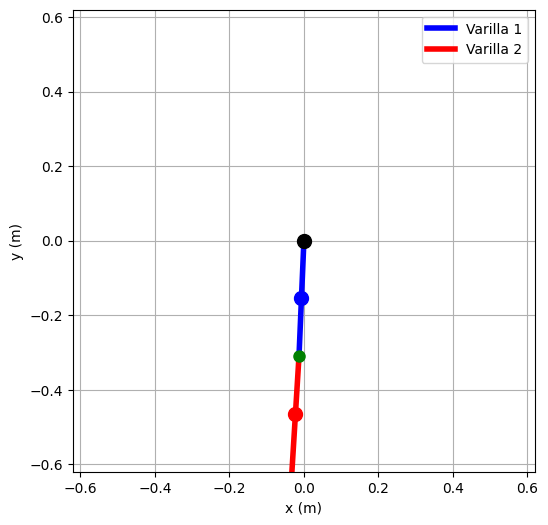

In [ ]:
# Calcular posiciones para la animación
x1 = l/2 * np.sin(theta1)
y1 = -l/2 * np.cos(theta1)
x2 = l * np.sin(theta1) + l/2 * np.sin(theta2)
y2 = -l * np.cos(theta1) - l/2 * np.cos(theta2)
x_pivot2 = l * np.sin(theta1)
y_pivot2 = -l * np.cos(theta1)

# Configurar la figura
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2*l, 2*l)
ax.set_ylim(-2*l, 2*l)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.grid(True)
ax.set_aspect('equal')

# Graficar elementos
line1, = ax.plot([], [], 'b-', lw=4, label='Varilla 1')  # Primera varilla
line2, = ax.plot([], [], 'r-', lw=4, label='Varilla 2')  # Segunda varilla
point1, = ax.plot([], [], 'bo', ms=10)  # Centro de la primera varilla
point2, = ax.plot([], [], 'ro', ms=10)  # Centro de la segunda varilla
pivot, = ax.plot(0, 0, 'ko', ms=10)  # Pivote fijo
pivot2, = ax.plot([], [], 'go', ms=8)  # Pivote móvil
ax.legend()

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    point1.set_data([], [])
    point2.set_data([], [])
    pivot2.set_data([], [])
    return line1, line2, point1, point2, pivot2

def animate(i):

    # Primera varilla: del origen al pivote 2
    line1.set_data([0, x_pivot2[i]], [0, y_pivot2[i]])
    # Segunda varilla: del pivote 2 al final
    line2.set_data([x_pivot2[i], x_pivot2[i] + l * np.sin(theta2[i])],
                   [y_pivot2[i], y_pivot2[i] - l * np.cos(theta2[i])])
    # Centro de masa
    point1.set_data([x1[i]], [y1[i]])
    point2.set_data([x2[i]], [y2[i]])
    pivot2.set_data([x_pivot2[i]], [y_pivot2[i]])
    return line1, line2, point1, point2, pivot2

# Crear animación
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(t),
                             interval=1000*t_eval[1], blit=True)

# Mostrar en Colab
HTML(ani.to_jshtml())

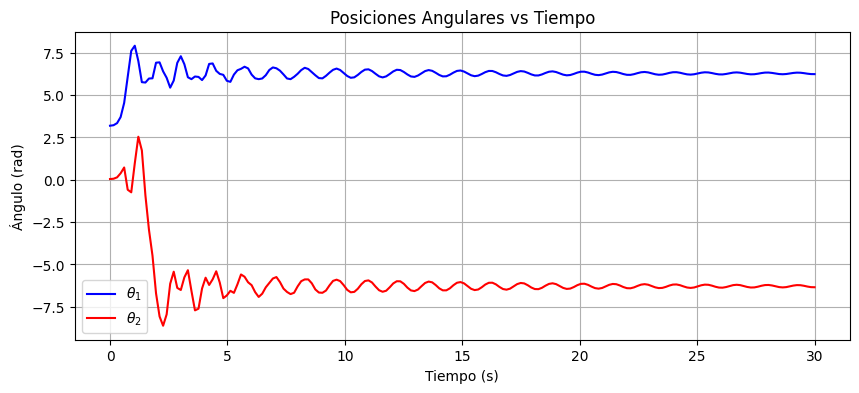

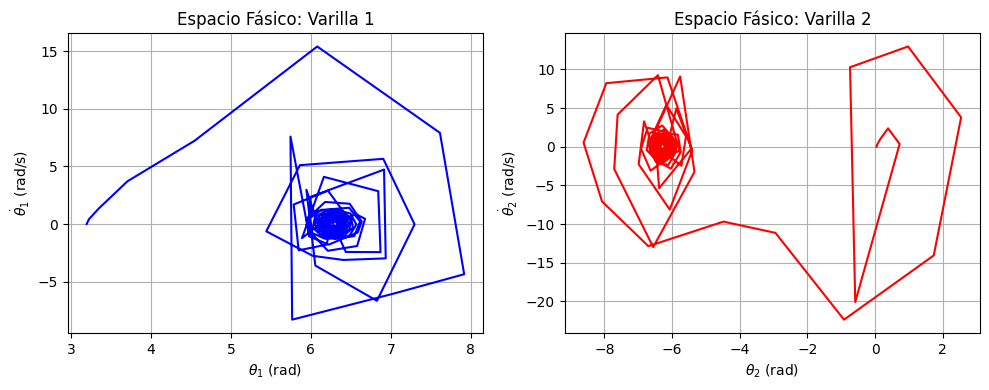

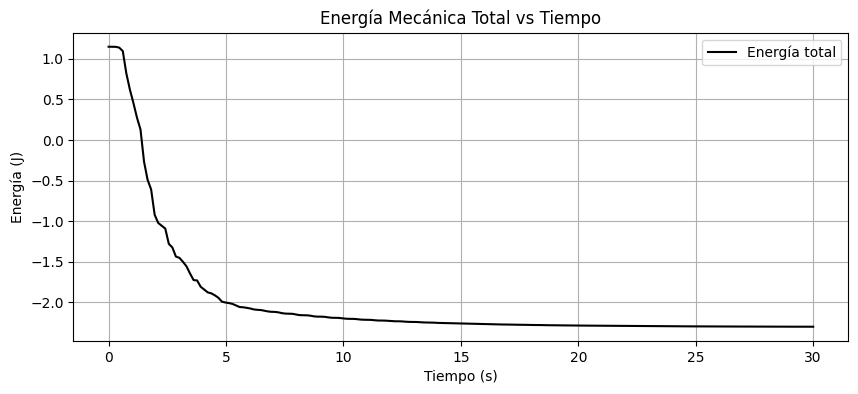

In [ ]:
# Compute kinetic and potential energy for diagnostics
T = (2/3) * m * l**2 * dtheta1**2 + (1/6) * m * l**2 * dtheta2**2 + (1/2) * m * l**2 * np.cos(theta1 - theta2) * dtheta1 * dtheta2
V = -(3/2) * m * g * l * np.cos(theta1) - (1/2) * m * g * l * np.cos(theta2)
E_total = T + V

# Plot angles vs time
plt.figure(figsize=(10, 4))
plt.plot(t, theta1, 'b-', label=r'$\theta_1$')
plt.plot(t, theta2, 'r-', label=r'$\theta_2$')
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Posiciones Angulares vs Tiempo')
plt.legend()
plt.grid(True)
plt.show()

# Plot phase spaces
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(theta1, dtheta1, 'b-')
plt.xlabel(r'$\theta_1$ (rad)')
plt.ylabel(r'$\dot{\theta}_1$ (rad/s)')
plt.title('Espacio Fásico: Varilla 1')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(theta2, dtheta2, 'r-')
plt.xlabel(r'$\theta_2$ (rad)')
plt.ylabel(r'$\dot{\theta}_2$ (rad/s)')
plt.title('Espacio Fásico: Varilla 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot total energy
plt.figure(figsize=(10, 4))
plt.plot(t, E_total, 'k-', label='Energía total')
plt.xlabel('Tiempo (s)')
plt.ylabel('Energía (J)')
plt.title('Energía Mecánica Total vs Tiempo')
plt.legend()
plt.grid(True)
plt.show()